#### **This code accompanies the IEEE Access Journal: "Compact Model Parameter Extraction via Derivative-Free Optimization"**
**Paper link:** https://ieeexplore.ieee.org/abstract/document/10662920

*Written by Rafael Perez Martinez (Stanford University)*

Note: Before running this diode example, it is necessary to install NGSPICE, OpenVAF, and Optuna. This notebook is designed to be run in [Google Colab](https://colab.google/). It is recommended using a TPU for faster simulation time.

In [1]:
"""
MIT License

Copyright (c) 2024 Rafael Perez Martinez

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
""";

In [2]:
# NGSPICE Installation (can take up to 5-10 mins)
%%capture
!apt-get update
!apt-get install -y libxaw7-dev libxaw7
!wget http://sourceforge.net/projects/ngspice/files/ng-spice-rework/42/ngspice-42.tar.gz -O ngspice-42.tar.gz
!tar -zxvf ngspice-42.tar.gz
%cd ngspice-42
!./configure --enable-xspice --enable-osdi --disable-debug --with-readline=yes
!make clean
!make
!make install
!which ngspice
!ngspice --version

In [3]:
# Optuna installation
%%capture
!pip install optuna

In [4]:
# Download extract_model Python module
url_module = 'https://raw.githubusercontent.com/rafapm/dfo_parameter_extraction/refs/heads/main/notebooks/extract_model.py'
!wget -P /content/ {url_module}

--2024-10-08 17:01:57--  https://raw.githubusercontent.com/rafapm/dfo_parameter_extraction/refs/heads/main/notebooks/extract_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61501 (60K) [text/plain]
Saving to: ‘/content/extract_model.py’

extract_model.py    100%[===================>]  60.06K  --.-KB/s    in 0.01s   

2024-10-08 17:01:58 (4.02 MB/s) - ‘/content/extract_model.py’ saved [61501/61501]



#### This example corresponds to Section III(c) (Diamond Schottky Diode Fitting Example) of the journal



In [5]:
import os
import json
import numpy as np
import pandas as pd

import importlib
import extract_model
importlib.reload(extract_model)
from extract_model import ExtractModel

In [6]:
# Instantiate the class
diode = ExtractModel(device_type='diode')

# Set inputs (voltage columns) and outputs (measured columns)
inputs = ['va']  # For diode (one voltage input)
outputs = ['ia']  # For diode (one measured output)
diode.set_inputs_outputs(inputs=inputs, outputs=outputs)

# Set delta and epsilon for hyperparameters
delta=np.sqrt(0.15)
epsilon={'ia': 1e-10}
diode.set_hyperparameters(delta, epsilon)

# Provide data url (from GitHub) and choose start, end, and step voltages
url = 'https://raw.githubusercontent.com/rafapm/dfo_parameter_extraction/main/notebooks/Diode_ex/ngspice_notebook_and_files/diamond_diode_meas.csv'

# Voltages:  ['va']
start_vals = [0.48]  # Start value for va
end_vals = [2]  # End value for va
step_sizes = [0.04]  # Step size for va

# Process data and do a train/test split
diode.run_data_process(file_path=url, step_sizes=step_sizes, start_vals=start_vals, end_vals=end_vals)
print(f"va: start={diode.voltages_sweep['va_start']}, stop={diode.voltages_sweep['va_stop']}, step={diode.voltages_sweep['va_step']}")

va: start=0.48, stop=2.0, step=0.04


### **Note:** This method is probabilistic (i.e., you get a different result everytime you run it)
### You can make it deterministic by changing the sampler_behavior to 1 and adding a seed_value

[I 2024-10-08 17:03:28,080] A new study created in memory with name: no-name-ae16e4b5-7893-47c3-ac11-d038165b96b6
[I 2024-10-08 17:03:28,124] Trial 0 finished with value: 0.12033859736767963 and parameters: {'N': 1.0507979025745755, 'IS': 1.3318136687429908e-23, 'RS': 114.54523694564722}. Best is trial 0 with value: 0.12033859736767963.
[I 2024-10-08 17:03:28,148] Trial 1 finished with value: 0.1183339133688629 and parameters: {'N': 1.010827605197663, 'IS': 4.773543263868096e-23, 'RS': 144.8146544466719}. Best is trial 1 with value: 0.1183339133688629.
[I 2024-10-08 17:03:28,170] Trial 2 finished with value: 0.14427341318333214 and parameters: {'N': 0.6255853104638363, 'IS': 4.185319668991098e-25, 'RS': 102.57336016504149}. Best is trial 1 with value: 0.1183339133688629.
[I 2024-10-08 17:03:28,195] Trial 3 finished with value: 0.11631717588497315 and parameters: {'N': 0.9408098436506365, 'IS': 1.2292172115487824e-25, 'RS': 122.84166121973556}. Best is trial 3 with value: 0.116317175884

Best parameters saved to /content/best_parameters_train_test_split.json
Results saved to /content/study_results.csv
Simulation data saved to: /content/sim_clipped_all_data.csv
Reshape dimensions based on inputs ['va']: (39,)


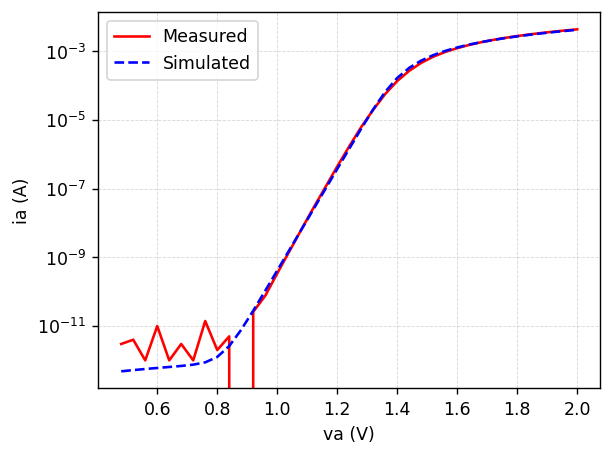

In [7]:
# Define model parameter configuration for optimization
original_param_config = {
    "N": {"min": 0.5, "max": 1.5, "scale": "lin"},
    "IS": {"min": 1e-25, "max": 1e-22, "scale": "log"},
    "RS": {"min": 100, "max": 150, "scale": "lin"}
}

# Run optimization
diode.run_optuna_optimization(
    num_trials=250,  # Provide number of trials
    sampler_behavior=1,  # 0 for probabilistic and 1 for deterministic
    seed_value=3,  # If deterministic, define the seed value here
    best_params_filename="best_parameters_train_test_split.json",
    results_filename="study_results.csv",
    param_config=original_param_config,  # Pass the parameter config
    use_all_data=False  # If using train/test dataset, choose False
)

# Load the best parameters from the JSON file
best_params_train_test_split="best_parameters_train_test_split.json"

with open(f'/content/{best_params_train_test_split}', 'r') as f:
    best_params = json.load(f)

# Simulate and evaluate using the best parameters
results = diode.simulate_and_evaluate(**best_params)

# Plot the simulation results
diode.plot_simulation_results()

### Retrain (with fewer trials) using all data and with tighter parameter ranges


[I 2024-10-08 17:03:42,371] A new study created in memory with name: no-name-43aa90ce-ef40-4a84-abdd-1644ec0fb1ec
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[I 2024-10-08 17:03:42,402] Trial 0 finished with value: 0.008428643105268467 and parameters: {'N': 1.1423025519014856, 'IS': 6.572758211875424e-25, 'RS': 123.69513182456627}. Best is trial 0 with value: 0.008428643105268467.
[I 2024-10-08 17:03:42,427] Trial 1 finished with value: 0.0830680421039868 and parameters: {'N': 1.1138667591675098, 'IS': 6.94592356417563e-25, 'RS': 105.14510633331399}. Best is trial 0 with value: 0.008428643105268467.
[I 2024-10-08 17:03:42,453] Trial 2 finished with value: 0.0983158470820484 and parameters: {'N': 1.0745637498883

Using all available data for optimization.
Enqueued initial parameters from /content/best_parameters_train_test_split.json


[I 2024-10-08 17:03:42,571] Trial 7 finished with value: 0.09632046024672947 and parameters: {'N': 1.0190664765795545, 'IS': 5.93161740203252e-25, 'RS': 134.85532354491912}. Best is trial 0 with value: 0.008428643105268467.
[I 2024-10-08 17:03:42,598] Trial 8 finished with value: 0.10577678135932178 and parameters: {'N': 1.302771469771989, 'IS': 6.142038976517813e-25, 'RS': 130.83194321398463}. Best is trial 0 with value: 0.008428643105268467.
[I 2024-10-08 17:03:42,623] Trial 9 finished with value: 0.09945986377122698 and parameters: {'N': 1.271287638654226, 'IS': 7.321660278706406e-25, 'RS': 108.2967285317716}. Best is trial 0 with value: 0.008428643105268467.
[I 2024-10-08 17:03:42,673] Trial 10 finished with value: 0.10390054386866562 and parameters: {'N': 1.2195753841286303, 'IS': 6.789977681488268e-25, 'RS': 141.0320664213095}. Best is trial 0 with value: 0.008428643105268467.
[I 2024-10-08 17:03:42,726] Trial 11 finished with value: 0.03397715725439727 and parameters: {'N': 1.15

Best parameters saved to /content/best_parameters_all_data.json
Results saved to /content/study_results_all_data.csv
Simulation data saved to: /content/sim_clipped_all_data.csv
Reshape dimensions based on inputs ['va']: (39,)


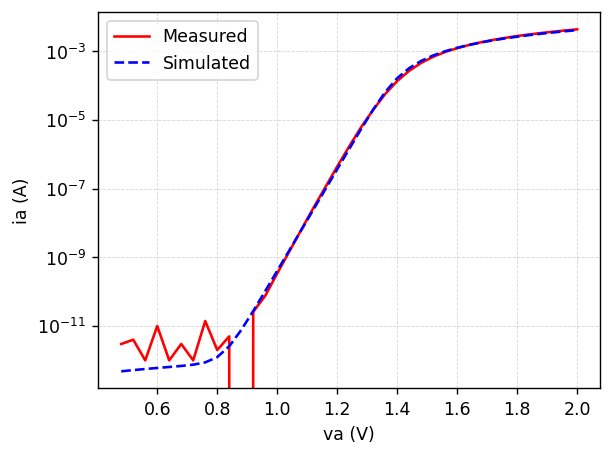

In [8]:
# Generate new param_config based on percentage_window to tighten parameter ranges
initial_params_file=f'/content/{best_params_train_test_split}'
percentage_window=0.15
best_params = diode.load_parameters_from_json(initial_params_file)
param_config_new = diode.generate_param_config_from_best_params(original_param_config=original_param_config, best_params=best_params, percentage=percentage_window)
best_parameters_all_data="best_parameters_all_data.json"

# Run optimization
diode.run_optuna_optimization(
    num_trials=100, # Provide number of trials
    sampler_behavior=1, # 0 for probabilistic and 1 for deterministic
    seed_value=1, # If deterministic, define the seed value here
    best_params_filename="best_parameters_all_data.json",
    results_filename="study_results_all_data.csv",
    param_config=param_config_new,
    use_all_data=True, # If using all data, choose True
    initial_params_file=initial_params_file
)

# Load the best parameters from the JSON file
with open(f'/content/{best_parameters_all_data}', 'r') as f:
    best_params = json.load(f)

# Simulate and evaluate using the best parameters
results = diode.simulate_and_evaluate(**best_params)

# Plot the simulation results
diode.plot_simulation_results()